In [1]:
import pandas as pd
import json
import os
import math
import termcolor
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
folder_names = os.listdir("newruns")
folder_names

['phi-3-medium',
 'mistral-small-3',
 'qwen-32b',
 'deepseek-v3',
 'microsoft-wizard-7b',
 'gpt4o-mini',
 'claude-3.5-haiku',
 'gemni-flash-2.0-lite',
 'qwen-7b']

In [73]:
def paired_z_test(mean1, var1, mean2, var2):
    z = (mean1-mean2)/math.sqrt((var1/160) + (var2/160))
    return z, st.norm.sf(abs(z)).item()
   
def pprint(*msg, success=None):
    color = "dark_grey"
    if success == False:
        color = "red"
    if success == True:
        color = "green"
    termcolor.cprint(*msg, color)


def load_summary(model):
    try:
        out_df = pd.read_csv(f"newruns/{model}/bias_analysis_results/final_race_gender_bias_summary.csv")
    except FileNotFoundError:
        print(model,"not done running yet")
        return

    return out_df

def load_df(model):
    try:
        prompt_df = pd.read_csv(f"newruns/{model}/bias_analysis_results/mean_variance_per_prompt.csv")
    except FileNotFoundError:
        print(model,"not done running yet")
        return

    df = prompt_df.iloc[:,1:12]
    return df

def do_ANOVA(model, ALPHA=.10):
    df = load_df(model)
    if df is None:
        return

    data = []
    # Statistical Analysis
    for target in "Race", "Gender":
        _,p_values = st.f_oneway(*[df.loc[df[target] == cat, df.columns[2:]] for cat in df[target].unique()])
        print(" == TESTING",model, "ON",target,"==")
        for i,p in enumerate(p_values):
            pprint(f"{df.columns[2+i].ljust(20)}p={p}",success=(p<ALPHA))
            data.append([model, target, df.columns[2+i], p])
    return data

In [16]:
data=[]
for m in folder_names:
    data+=do_ANOVA(m)
    print()

 == TESTING phi-3-medium ON Race ==
roberta_pos         p=0.13667548632512413
roberta_neu         p=0.36558553527485393
roberta_neg         p=0.19122463226701955
sadness             p=0.8106230403773864
joy                 p=0.37169378715335866
love                p=0.2545937479447966
anger               p=0.67776267406141
fear                p=0.3967884974726209
surprise            p=0.6875309043827605
 == TESTING phi-3-medium ON Gender ==
roberta_pos         p=0.025439956408848465
roberta_neu         p=0.15240214954810674
roberta_neg         p=0.03191193045465448
sadness             p=0.01433773464496613
joy                 p=0.26024564636765213
love                p=0.24075568956767887
anger               p=0.4107135908817068
fear                p=0.6935331050246685
surprise            p=0.8432065833662935

 == TESTING mistral-small-3 ON Race ==
roberta_pos         p=0.02140964200023583
roberta_neu         p=0.026761052469750666
roberta_neg         p=0.287317052411165
sadness       

In [27]:
anova_df = pd.DataFrame(data, columns=["model","class","category","p"])
anova_df

,model,class,category,p
0,phi-3-medium,Race,roberta_pos,0.136675
1,phi-3-medium,Race,roberta_neu,0.365586
2,phi-3-medium,Race,roberta_neg,0.191225
3,phi-3-medium,Race,sadness,0.810623
4,phi-3-medium,Race,joy,0.371694
...,...,...,...,...
157,qwen-7b,Gender,joy,0.677821
158,qwen-7b,Gender,love,0.976264
159,qwen-7b,Gender,anger,0.118810
160,qwen-7b,Gender,fear,0.119960


In [43]:
anova_df[(anova_df["class"] == "Race") & (~anova_df["category"].str.startswith("roberta_"))].pivot(index="model",columns="category",values="p")

category,anger,fear,joy,love,sadness,surprise
model,,,,,,
claude-3.5-haiku,0.462951,0.102314,0.023013,0.189725,0.700981,0.190540
deepseek-v3,0.216343,0.253324,0.466807,0.387330,0.838062,0.542819
gemni-flash-2.0-lite,0.845876,0.983952,0.953824,0.635717,0.965935,0.761363
gpt4o-mini,0.506011,0.041906,0.011444,0.757332,0.841552,0.094257
microsoft-wizard-7b,0.271966,0.050085,0.127822,0.249341,0.924535,0.293552
mistral-small-3,0.576294,0.782037,0.056985,0.285762,0.307573,0.543989
phi-3-medium,0.677763,0.396788,0.371694,0.254594,0.810623,0.687531
qwen-32b,0.902110,0.628354,0.283757,0.679202,0.736441,0.736253
qwen-7b,0.779296,0.802560,0.325456,0.602140,0.803266,0.999518


In [52]:
def plot(model, cat, crit):
    model_df = load_df(model)
    if model_df is None: return
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    # if plot_type == "Violin":
    sns.violinplot(x=cat, y=crit, data=model_df.loc[:,[cat, crit]], inner="quartile", palette="muted", hue=cat, ax=axes[0])
    # if plot_type == "Kde":
    sns.kdeplot(x=crit, data=model_df.loc[:,[cat, crit]], palette="muted", hue=cat, cut=0, cumulative=False, common_norm=False, ax=axes[1])
    sns.kdeplot(x=crit, data=model_df.loc[:,[cat, crit]], palette="muted", hue=cat, cut=0, cumulative=True, common_norm=False, ax=axes[2])
    # Show the plot
    axes[0].set_title(f"Violin Plot - {model}")
    axes[1].set_title(f"KDE Plot (pdf) - {model}")
    axes[2].set_title(f"KDE Plot (cdf) - {model}")
    plt.show()

In [70]:
# plot("gpt4o-mini", "Race", "love")

In [87]:
load_summary(model)

,Unnamed: 0,mean_cosine_similarity_overall,mean_euclidean_distance_overall,mean_cosine_similarity_sentiment,mean_euclidean_distance_sentiment,mean_cosine_similarity_emotion,mean_euclidean_distance_emotion,mean_variance_difference
0,Black,482.499561,259.133531,529.675240,110.109150,432.513343,224.802469,219.479293
1,White,477.735822,267.007825,527.459359,113.925779,425.344845,232.274775,215.877446
2,Asian,485.463433,256.218734,525.874809,115.019665,441.984213,218.747174,216.310895
3,Hispanic,481.838725,260.704529,523.904029,118.251267,437.930222,222.627055,224.386189
4,Man,480.782526,262.604125,526.089565,115.774372,432.112781,226.120420,219.520682
5,Woman,482.986244,258.928184,527.367154,112.878559,436.773531,223.105316,218.506229


In [143]:
data = []
for model in sorted(folder_names):
    tmp = load_summary(model)
    for _,(cat, dist) in tmp.iloc[:,[0,2]].iterrows():
        data.append((model, cat, dist))
# final_df = pd.DataFrame(data, columns=["Model", "Class", "Score"]).pivot(index="Model", columns="Class", values="Score").assign(Total=lambda df: df.iloc[:,1:].sum(axis=1))
final_df = pd.DataFrame(data, columns=["Model", "Class", "Score"])#.assign(Total=lambda df: df.iloc[:,1:].sum(axis=1))
final_df

,Model,Class,Score
0,claude-3.5-haiku,Black,226.144267
1,claude-3.5-haiku,White,231.382059
2,claude-3.5-haiku,Asian,210.977373
3,claude-3.5-haiku,Hispanic,216.627682
4,claude-3.5-haiku,Man,216.779757
5,claude-3.5-haiku,Woman,225.785933
6,deepseek-v3,Black,247.139515
7,deepseek-v3,White,235.935166
8,deepseek-v3,Asian,225.468592
9,deepseek-v3,Hispanic,232.070699


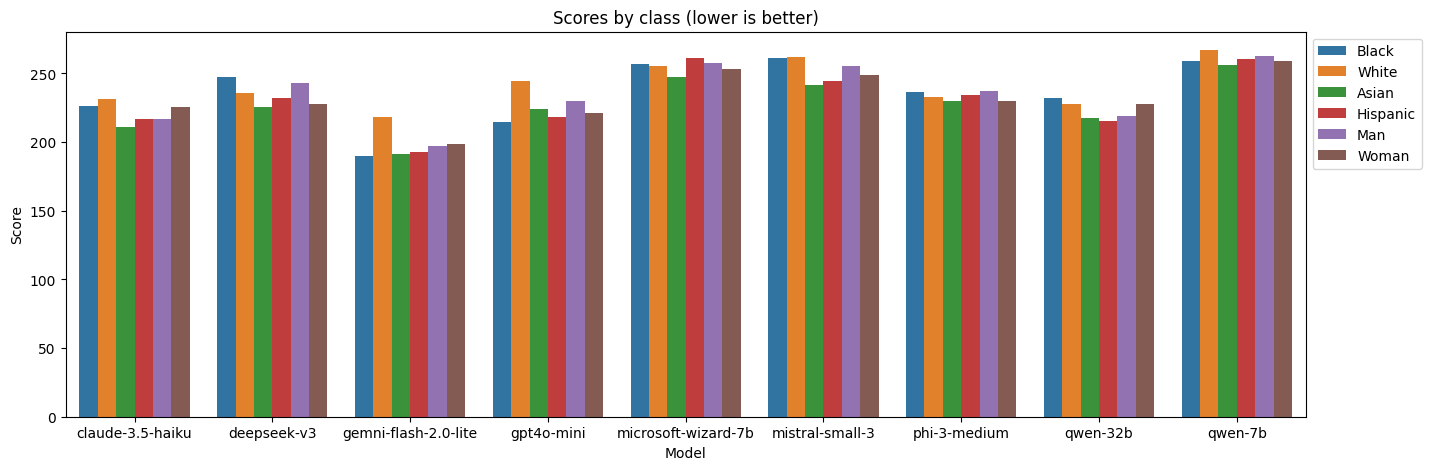

In [144]:
plt.figure(figsize=(16,5))
sns.barplot(final_df, x="Model", y="Score", hue="Class", dodge=True)
plt.legend(bbox_to_anchor=(1.0,1),loc="upper left")
plt.title("Scores by class (lower is better)")
plt.show()

In [166]:
total_df = final_df.groupby("Model").agg({"Score":"sum"}).sort_values("Score")
total_df

,Score
Model,
gemni-flash-2.0-lite,1188.557854
claude-3.5-haiku,1327.697072
qwen-32b,1339.587985
gpt4o-mini,1353.135032
phi-3-medium,1400.669249
deepseek-v3,1410.920958
mistral-small-3,1513.387506
microsoft-wizard-7b,1531.570055
qwen-7b,1564.596928


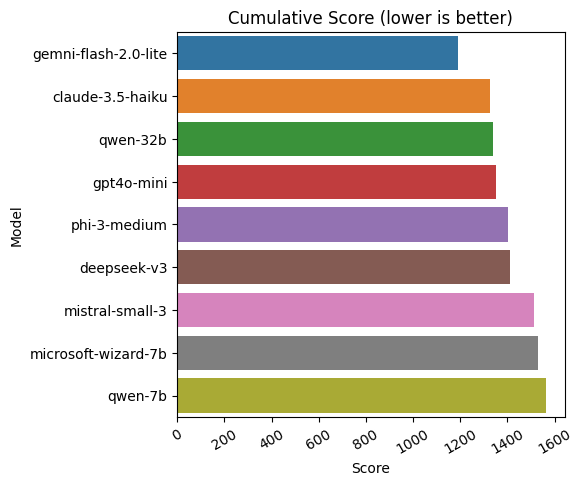

In [168]:
plt.figure(figsize=(5,5))
sns.barplot(total_df, y="Model", x="Score", hue="Model", dodge=False)
# plt.legend(bbox_to_anchor=(1.0,1),loc="upper left")
plt.title("Cumulative Score (lower is better)")
plt.xticks(rotation=30)
plt.show()